In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [ ]:
# https://www.kaggle.com/datasets/yanmaksi/big-molecules-smiles-dataset?resource=download
df = pd.read_csv('SMILES_Big_Data_Set.csv')
df.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


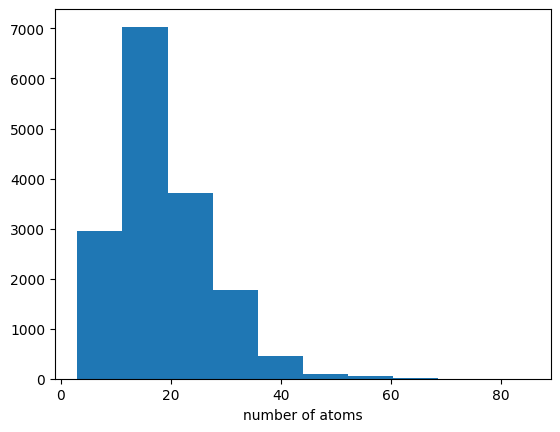

In [4]:
plt.hist(df['num_atoms'])
plt.xlabel('number of atoms')
plt.show()

In [5]:
# build one-hot encoder (list of lists)
def build_dict_list(split_string: str, smile_dict_list: list) -> list:
    for c in split_string:
        if c not in smile_dict_list:
            smile_dict_list.append(c)
    return smile_dict_list

def make_dict(smile_dict_list: list) -> dict:
    smile_dict = {}
    for i, c in enumerate(smile_dict_list):
        smile_dict[c] = i
    return smile_dict

def encoder(split_string: list, smile_dict: list, max_mol_len: int) -> list[list]:
    # print(split_string)

    encoded_smile = []
    for i, c in enumerate(split_string):
        if i < max_mol_len: # truncate if greater than max_mol_len
            one_hot = [0]*len(smile_dict)
            one_hot[smile_dict[c]] = 1
            encoded_smile.append(one_hot)

    # zero pad
    while len(encoded_smile) < max_mol_len:
        encoded_smile.append([0]*len(smile_dict))

    return encoded_smile

In [6]:
def split_strings(smile_str: str) -> list:
    del_char = ['[',']']
    for d in del_char:
        smile_str = smile_str.replace(d,'')

    two_let_el = ['Cl','Br','Si','Se','se'] # two letter elements to check for

    mol_list = []
    skip = False
    for i,c in enumerate(smile_str):
        if not skip and i < len(smile_str)-1:
            potential_el = ''.join([smile_str[i],smile_str[i+1]])
            if potential_el in two_let_el:
                skip = True
                mol_list.append(potential_el)
            if not skip:
                mol_list.append(c)
        elif not skip and i == len(smile_str)-1:
            mol_list.append(c)
        else:
            skip = False

    return mol_list

# split test and train
def data_split(df, test_frac=0.2):
    ind = np.random.choice(len(df), size=int(test_frac*len(df)), replace=False)
    df_test = df.iloc[ind]
    df_train = df.drop(ind)
    return df_test.reset_index(), df_train.reset_index()

In [7]:
# data preprocessing
max_mol_len = 40
df1 = df[df['num_atoms'] <= max_mol_len].dropna()
df2 = df1.reset_index()

# split test and train
df_test, df_train = data_split(df2[['SMILES', 'pIC50']])

# break string into list of characters
ss_test = [split_strings(df_test['SMILES'][i]) for i in range(len(df_test))]
ss_train = [split_strings(df_train['SMILES'][i]) for i in range(len(df_train))]

# make list of unique characters for dict
smile_dict_list = []
for i in reversed(range(len(ss_train))):
    smile_dict_list = build_dict_list(ss_train[i], smile_dict_list)

# build dict
smile_dict = make_dict(smile_dict_list)
dict_len = len(smile_dict)
print(smile_dict)

# make one-hot encoding of molecules using dict
encoded_smile_train = [encoder(ss_train[i],smile_dict,max_mol_len) for i in range(len(ss_train))]
encoded_smile_test = [encoder(ss_test[i],smile_dict,max_mol_len) for i in range(len(ss_test))]

# convert data to torch tensor
x_train = torch.Tensor(encoded_smile_train)
y_train = torch.Tensor(df_train['pIC50'])
x_test = torch.Tensor(encoded_smile_test)
x_test = x_test.unsqueeze(1)
y_test = torch.Tensor(df_test['pIC50'])

{'N': 0, '=': 1, '+': 2, 'C': 3, 'c': 4, '1': 5, '(': 6, 'O': 7, ')': 8, '-': 9, 'o': 10, 'S': 11, 'n': 12, 'H': 13, '2': 14, '3': 15, 'Cl': 16, 's': 17, '#': 18, 'Br': 19, 'I': 20, 'F': 21, '4': 22, 'P': 23, '5': 24, '6': 25, 'Se': 26, 'Si': 27, 'se': 28, '7': 29}


In [8]:
# model and training functions

# make model
class conv_model(nn.Module):
    def __init__(self, kernel_size, max_mol_len, dict_len, in_channels=1, out_channels=2):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        H_out = max_mol_len - kernel_size[0] + 1
        W_out = dict_len - kernel_size[1] + 1
        self.fc = nn.Linear(H_out*W_out*out_channels, 1)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return self.fc(x.flatten(1))

In [9]:
# training loop for SGD

def train_loop(lr, x_train, y_train, x_test, y_test, config):
    conv_mod = conv_model(config['kernel_size'], config['max_mol_len'], config['dict_len'])
    conv_mod = conv_mod.to(device=config['device'])
    optimizer = torch.optim.Adam(conv_mod.parameters(), lr=lr)
    loss = nn.MSELoss()
    error = []
    error_test = []

    for _ in range(config['N_epochs']):
        conv_mod.train()

        ind = list(range(x_train.shape[0]))
        random.shuffle(ind)

        for i in ind:
            x_samp = x_train[i].unsqueeze(0).unsqueeze(0).to(config['device']) # adding in channel dimension

            y_pred = conv_mod(x_samp)
            # print(y_pred.shape,y_train[i].shape)

            optimizer.zero_grad()

            mseloss = loss(y_pred.to(config['device']), y_train[i].unsqueeze(0).unsqueeze(0).to(config['device']))
            error.append(mseloss.item())
            mseloss.backward()
            optimizer.step()

        # evaluation
        conv_mod.eval()
        y_pred = conv_mod(x_test.to(config['device']))
        mseloss = loss(y_pred, y_test.unsqueeze(1).to(config['device']))
        error_test.append(mseloss.item())

    return error, error_test

one complete
one complete
one complete


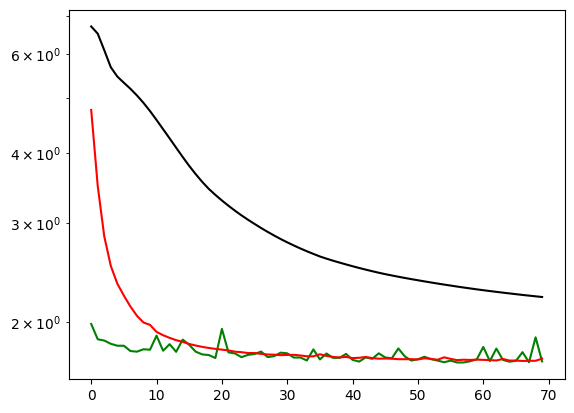

In [11]:
N_epochs = 70
kernel_size = [2,dict_len]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {"N_epochs": N_epochs,
          "kernel_size": kernel_size,
          "device": device,
          "max_mol_len": max_mol_len,
          "dict_len": dict_len}


lr = [1e-3, 1e-4, 1e-5]
col = ['g','r','k']
for i,l in enumerate(lr):
    error, error_test = train_loop(l, x_train, y_train, x_test, y_test, config)
    print('one complete')
    # plt.plot(range(N_epochs), error, color=col[i], linestyle='--')
    plt.plot(range(N_epochs), error_test, color=col[i])
plt.yscale('log')
plt.show()